In [1]:
import os
import glob
import copy
import pickle
import itertools
import numpy as np
import collections
from pathlib import Path
from matplotlib import pyplot as plt
from plotting import plot_est_and_gt_ellipses_on_images, plot_3D_scene
from lfd import compute_estimates, dual_quadric_to_ellipsoid_parameters

In [2]:
# Utilities
def read_list_poses(list):
    for idx, file_path in enumerate(list):
        with open(file_path) as f_input:
            pose = np.transpose(np.loadtxt(f_input)[:3, :])
            if idx == 0:
                poses = pose
            else:
                poses = np.concatenate((poses, pose), axis=0)
    return poses


def read_list_box(list):
    corpus = []
    for file_path in list:
        with open(file_path) as f_input:
            line = f_input.read()
            corpus.append([int(number) for number in line.split(",")])
    return np.array(corpus)

    
def sort_poses(pose_list):
    files = {int(Path(file).stem) : file for file in pose_list}
    ordered_dict = collections.OrderedDict(sorted(files.items()))
    return ordered_dict.values()


def dual_quadric_to_ellipsoid_parameters(Q):
    """Computes centre, axes length and orientation of one ellipsoid.

   A [4x4] matrix can represent general quadrics. In spite of preconditioning, the estimated quadrics can still,
   in rare cases, represent something other than ellipsoids. This is corrected by forcing the lengths of the
   axes to be positive.

    :param Q: Ellipsoid/Quadric in dual form [4x4].

    :returns:
      - centre - Ellipsoid centre in Cartesian coordinates [3x1].
      - axes - Length of ellipsoid axes [3x1].
      - R - Orientation of the ellipsoid [3x3].
    """

    # Scale the ellipsoid to put it in the usual form, with Q[3,3] = -1.
    Q = Q / (-Q[3, 3])

    # Compute ellipsoid centred on origin.
    centre = -Q[:3, 3]
    T = np.vstack((np.array((1, 0, 0, -centre[0])), np.array((0, 1, 0, -centre[1])),
                   np.array((0, 0, 1, -centre[2])), np.array((0, 0, 0, 1))))
    Qcent = T.dot(Q).dot(T.transpose())

    # Compute axes and orientation.
    [D, V] = np.linalg.eig(Qcent[:3, :3])
    sort_ev = np.argsort(D)
    V = np.vstack((V[:, sort_ev[0]], V[:, sort_ev[1]], V[:, sort_ev[2]])).transpose()
    D.sort()
    if sum(D < 0) > 0:
        # Take the absolute value of eigenvalues (they can be negative because of numerical issues).
        for index in range(D.shape[0]):
            if D[index] < 0:
                D[index] *= -1

    a = np.sqrt(D[0])
    b = np.sqrt(D[1])
    c = np.sqrt(D[2])
    
    axes = np.array([a, b, c])
    R = V
    return centre, axes, R

Load the input data.
Data association is implicitly defined in the data structures: each column of "visibility" corresponds to one object.
The information in "bbs" is structured in a similar way, with four columns for each object.

In [3]:
#dataset = "Aldoma"
dataset = "tiger"

save_output_images = True
random_downsample = False

if dataset != "Aldoma":
    PATH = f"data/{dataset}"
    box_list = glob.glob(os.path.join(os.getcwd(), f"{PATH}/bounding_boxes", "*.txt"))
    raw_poses_list = glob.glob(os.path.join(os.getcwd(), f"{PATH}/poses_ba", "*.txt"))
    poses_list = sort_poses(raw_poses_list)
    intrinsics = f"{PATH}/intrinsics.txt"
    bbs = read_list_box(box_list)
    Ms_t = read_list_poses(poses_list)
    visibility = np.ones((bbs.shape[0], 1))
    with open(intrinsics) as f:
        intr = f.readlines()
        K = np.array(
            [
                [float(intr[0]), 0, float(intr[2])],
                [0, float(intr[1]), float(intr[3])],
                [0, 0, 1],
            ]
        )
else:
    bbs = np.load('data/{:s}/bounding_boxes.npy'.format(dataset))  
    K = np.load('data/{:s}/intrinsics.npy'.format(dataset))
    Ms_t = np.load('data/{:s}/camera_poses.npy'.format(dataset)) 
    visibility = np.load('data/{:s}/visibility.npy'.format(dataset)) 

original_vis = copy.deepcopy(visibility)

In [13]:
def compute_box_3d_from_ellipse(dim, location, R):
  # dim: 3 lenght width and height of the bbox
  # location: 3 coordinates of the center
  # rotation_y: 1
  # return: 8 x 3
  #c, s = np.cos(rotation_y), np.sin(rotation_y)
  #R = np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]], dtype=np.float32)
  l, w, h = dim[2], dim[1], dim[0]
  x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
  y_corners = [0,0,0,0,-h,-h,-h,-h]
  z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]

  corners = np.array([x_corners, y_corners, z_corners], dtype=np.float32)
  corners_3d = np.dot(R, corners) 
  corners_3d = corners_3d + np.array(location, dtype=np.float32).reshape(3, 1)
  return corners_3d.transpose(1, 0) 

def compute_box_3d_from_ellipse_valid(centre, axes_len, R ):
  mins = [c - ax / 2 for (ax, c) in zip(axes_len, centre)]
  maxs = [c + ax / 2 for (ax, c) in zip(axes_len, centre)]

  # Coordinates of the points mins and maxs
  points = np.array(list(itertools.product(*zip(mins, maxs))))

  # Points in the camera frame
  points = np.dot(points, R.T)
  return points

Compute the number of frames and the number of objects for the current dataset from the size of the visibility matrix.


Number of view to esitmate the objects: 7


/Users/PELLERITO/Desktop/mixed_reality_code/3D_bboxes/Bbox3D_estimation/plotting.py:218: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


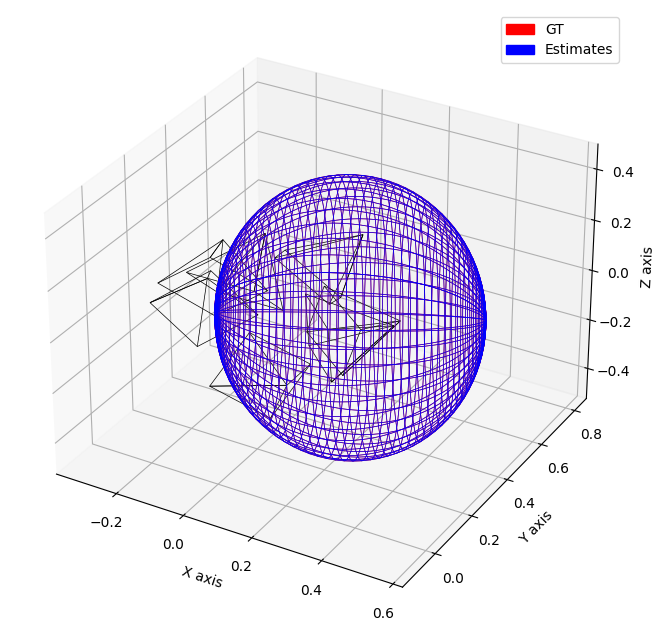

In [14]:
visibility = copy.deepcopy(original_vis)
indexes = [ind for ind, _ in enumerate(visibility) if ind%100!=0]
visibility[indexes] = 0

print(f"Number of view to esitmate the objects: {len(np.nonzero(visibility)[0])}")

n_frames, n_objects = visibility.shape
[inputCs, estCs, estQs] = compute_estimates(bbs, K, Ms_t, visibility)
Qs = estQs[0]
centre, axes_len, R = dual_quadric_to_ellipsoid_parameters(estQs[0])

corners_1 = compute_box_3d_from_ellipse_valid(centre, axes_len, R) # corners from Elisabetta-Lorenzo

corners = compute_box_3d_from_ellipse(dim=axes_len, location=centre, R=R) # corners from Roberto

# Plot ellipsoids and camera poses in 3D.
plot_3D_scene(
    estQs=estQs,
    gtQs=estQs,
    Ms_t=Ms_t,
    dataset=dataset,
    save_output_images=save_output_images,
    visibility=visibility
)
#plt.savefig("output/" + (5-len(f"{i}"))*"0" + f"{i}")
plt.show()

In [16]:
np.sum((corners_1 - corners )**2)

5.6857466540865005

In [17]:
corners_1

array([[ 0.11060854,  0.20416417,  0.03575398],
       [-0.20340874,  0.06187462,  0.01996793],
       [-0.04558302,  0.5183246 ,  0.31100364],
       [-0.35960031,  0.37603505,  0.29521759],
       [ 0.22559181, -0.09467037,  0.44208111],
       [-0.08842548, -0.23695992,  0.42629506],
       [ 0.06940024,  0.21949007,  0.71733077],
       [-0.24461705,  0.07720051,  0.70154471]])

In [18]:
corners

array([[ 0.02887002,  0.15852127,  0.11143459],
       [ 0.43462285,  0.34237863,  0.13183231],
       [ 0.35791647,  0.54173388, -0.13923224],
       [-0.04783636,  0.35787653, -0.15962995],
       [ 0.21006772, -0.20593596, -0.20788229],
       [ 0.61582055, -0.02207861, -0.18748458],
       [ 0.53911417,  0.17727665, -0.45854912],
       [ 0.13336134, -0.00658071, -0.47894683]])